# Other Models

In [1]:
import os
os.chdir("../../")

import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.forecasting.stl import STLForecast
import scipy
import pmdarima as pm
import itertools
import seaborn as sns
sns.set_style("whitegrid")

from scripts.python.tsa.utsmodel import *
from scripts.python.tsa.ts_eval import *


import warnings
warnings.filterwarnings("ignore")

{'MSE': 72015.06852111226, 'RMSE': 268.35623436229736, 'MAE': 183.9918355242541, 'SMAPE': 19.041351168822448}


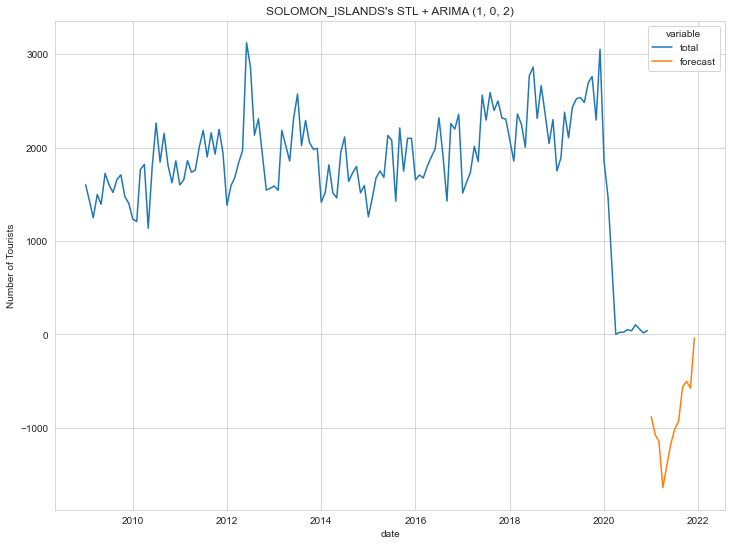

{'MSE': 1121059.1480585039, 'RMSE': 1058.8008066007997, 'MAE': 667.1143195672857, 'SMAPE': 26.300815822691483}


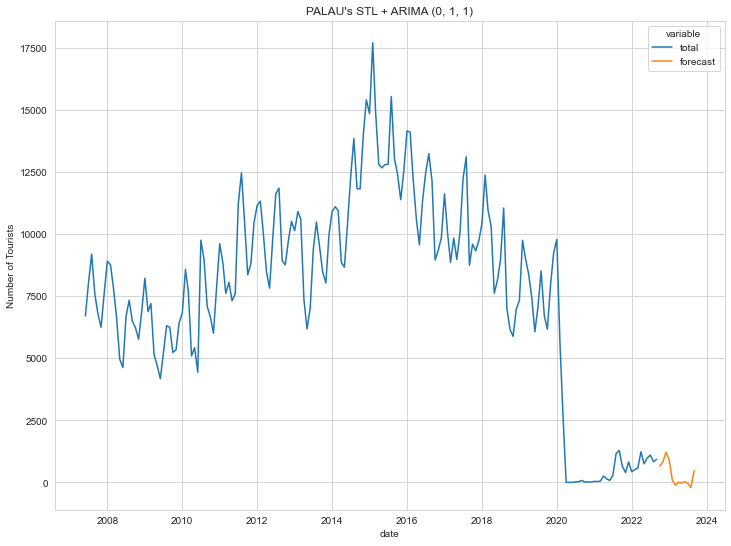

{'MSE': 1341021.2411779077, 'RMSE': 1158.0247152707527, 'MAE': 765.3878729336942, 'SMAPE': 29.526734316486404}


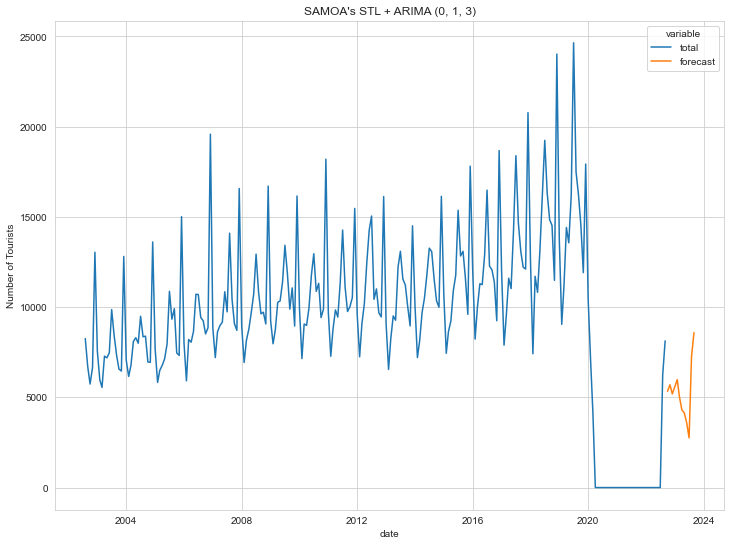

{'MSE': 714062.5186893714, 'RMSE': 845.0222001162878, 'MAE': 567.6206693964535, 'SMAPE': 31.472626058150194}


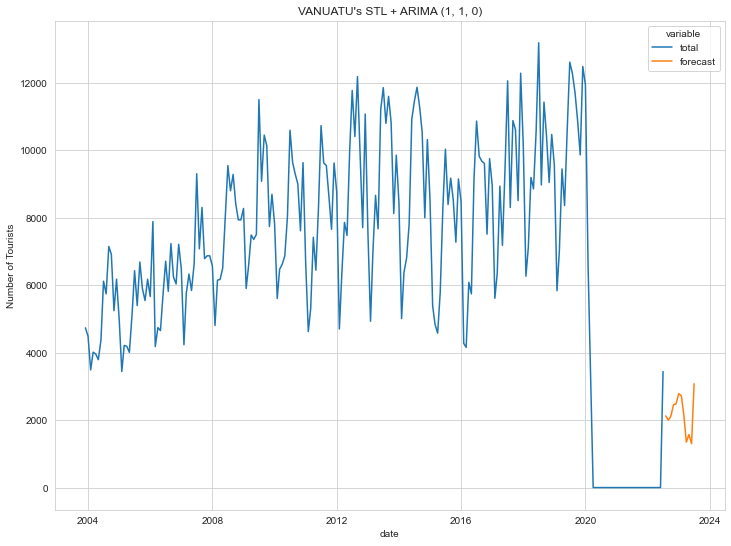

{'MSE': 388250.07828479045, 'RMSE': 623.0971660060655, 'MAE': 420.4074992719074, 'SMAPE': 36.35743495768548}


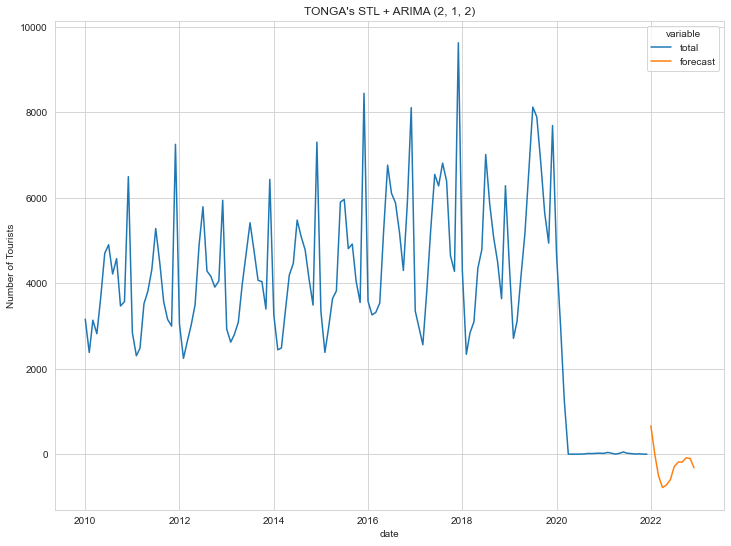

In [2]:
countries = ["solomon_islands", "palau", "samoa", "vanuatu", "tonga"]
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
for country in countries:

    mod = SARIMAXPipeline(country=country, y_var="total",
                          data=None,
                          exog_var=["covid", "stringency_index",
                                    str(country)+"_travel"],
                          transform_method="scaledlogit",
                          training_ratio=1,
                          verbose=False)
    mod.read_and_merge()

    stl = STL(mod.data["total"], period=12)
    stl_res = stl.fit()
    mod_val = stl_res.resid + stl_res.trend
    auto = pm.auto_arima(mod_val, trend="t")

    print(calculate_evaluation(
        mod.data["total"], stl_res.seasonal + auto.fittedvalues()))

    stlf = STLForecast(mod.data["total"], ARIMA, period=12, model_kwargs=dict(
        order=auto.order, trend="t"))
    stlf_res = stlf.fit()

    temp = pd.DataFrame(stlf_res.forecast(12), columns=["forecast"])
    temp = pd.concat([mod.data[["total"]], temp], axis=1)
    temp["date"] = pd.date_range(start=mod.data["date"][0], periods=len(temp), freq="MS")
    temp_viz = temp.melt(id_vars="date")
    
    fig, ax = plt.subplots(figsize=(12,9))
    sns.lineplot(data=temp_viz, x="date", y="value", hue="variable")
    plt.ylabel("Number of Tourists")
    plt.title(str(country).upper() + "'s STL + ARIMA " + str(auto.order))
    plt.show()